In [ ]:
!pip install nltk
!pip install spacy
!python -m spacy download es_core_news_sm
!pip install -U imbalanced-learn
!pip install pyspellchecker


In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

# Oculta warnings
import warnings
warnings.simplefilter('ignore')

In [ ]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

# CARGAR DATOS
**DATOS DE ENTRENAMIENTO**

la columna de trastornos indica si el TWEET es de una persona con depresión o es de control.


**control**:     0

**ansiedad**:   1

#DATOS DE PRUEBA

In [ ]:
ruta_archivo_entrenamiento = '/content/drive/MyDrive/Experimentación Python Tesis /entrenamiento y prueba (control vs ansiedad)/train.csv'
data_train = pd.read_csv(ruta_archivo_entrenamiento, sep=',')
data_train.info()
data_train.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64989 entries, 0 to 64988
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   USER_ID     32528 non-null  object 
 1   TWEET_ID    32528 non-null  float64
 2   TWEET_TEXT  64987 non-null  object 
 3   trastorno   64985 non-null  float64
dtypes: float64(2), object(2)
memory usage: 2.0+ MB


,USER_ID,TWEET_ID,TWEET_TEXT,trastorno
0,NaN,NaN,"3522.0, intenta combatir siéntete indeseable c...",1.0
1,302.0,2.147484e+09,"RT @giraltpablo: Lamentablemente, Ecuador perd...",0.0
2,NaN,NaN,Minitrigos helados ansiosos.,1.0
3,NaN,NaN,Está bien. Yo he estado ahí antes. Dudaba de m...,1.0
4,NaN,NaN,¡Siento escuchar eso! Considere la posibilidad...,1.0
5,480.0,2.147484e+09,"No entiendo eso de apoyar en una final,al equi...",0.0
6,266.0,2.147484e+09,"""Come On"" - @akapellah feat @BigSotoLuc &amp; ...",0.0
7,NaN,NaN,",Hola, chico, aparentemente tiene una enfermed...",1.0
8,390.0,2.147484e+09,"RT @excelentum: El que domina su cólera, domin...",0.0
9,288.0,2.147484e+09,RT @Guillodibujante: https://t.co/YO0oAArJJq,0.0


#Preprocesamiento de los datos

In [ ]:
import nltk
nltk.download('stopwords')  #Solamente se ha de descargar la primera vez.
stopwords_es = nltk.corpus.stopwords.words('spanish')   # Extrae las stopwords en español

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


*Eliminar etiquetas HTML*

In [ ]:
import re

def removeHTML(text):
    if isinstance(text, str):  # Verificar si es de tipo string
        cleanr = re.compile('<.*?>')
        cleantext = re.sub(cleanr, '', text)
        return cleantext
    else:
        return text  # Devolver el valor original si no es de tipo string

*Limpieza del texto*

In [ ]:
import re
import string

def clean(text):
    if isinstance(text, str):  # Verificar si es de tipo string
        # Eliminar hashtags
        text = re.sub(r'#\w+', '', text)

        # Eliminar URLs o enlaces
        text = re.sub(r'(https?://)?[a-zA-Z0-9]+\.[a-zA-Z0-9]+\S*', '', text)

        # Eliminar nombres de usuarios de Twitter
        text = re.sub(r'@\w+', '', text)

        # Eliminar Nombres propios
        text = re.sub(r'\b[A-Z][a-z]+\b', '', text)

        # Eliminar todos los caracteres especiales
        text = re.sub(r'[^\w\s]+', '', text)

        # Eliminar prefijos y números
        text = re.sub(r'\b\w{1,2}\b|\d+', '', text)

        # Eliminar palabras específicas
        specific_words = ['retweet', 'retweets', 'hashtag', 'trending', 'mención', 'enlace', 'emoji', 'timeline', 'interacciones',
                          'tuit', 'seguidores', 'notificaciones', 'seguir', 'favorito', 'perfil', 'tendencia', 'influencer',
                          'compartir', 'actualización', 'explorar', 'seguir', 'comunidad', 'contenido', 'popular',
                          'recomendar', 'experiencia', 'conectar', 'comentar', 'compartir', 'comunidad', 'actualización',
                          'drk', 'followers', 'stats', 'for', 'new', 'little', 'unfollower', 'unfollowers', 'today', 'shit','twitter','nombre',
                          'eric','story','great', 'short','squeeze','piggly','wiggly','hmv','even','follas','you','i','he','she',
                          'it','we','they','the','and','that','these','those','tweet','followed','follower']
        text = ' '.join([word for word in text.split() if word not in specific_words])

        # Eliminar emojis
        emojis = re.findall(r'[^\w\s,]', text)
        cleaned_emojis = [emoji for emoji in emojis if emoji not in ['@', '#', '/', '?','¿','.','…','"',':','“','!','¡','°','-',"‘",'’',
                                                                     '=',';','(',')',"'","'",'&','€','%','$','*','+','|', '”','🇦','🇷',',',
                                                                     ', ','—','«',' »','»','« ','[, ]','[,]',',',', ','',' ',' ♀',' 🏽']]
        for emoji in cleaned_emojis:
            text = text.replace(emoji, '')

        # Convertir el texto a minúsculas
        text = text.lower()

        # Eliminar signos de puntuación
        text = re.sub(f"[{re.escape(string.punctuation)}]", "", text)

        words = text.split() #divide el texto en palabras individuales, creando una lista de palabras.

      # Combinar las stopwords en  español
        all_stopwords = stopwords_es
      # Filtrar las stopwords del texto
        filtered_words = [word for word in words if word.lower() not in all_stopwords] #filtra las palabras vacías del texto que no están en la lista de palabras vacías

        # Unir las palabras filtradas en un solo texto
        text = ' '.join(filtered_words)

        # Devuelve el texto limpio
        return text
    else:
        return text  # Devolver el valor original si no es de tipo string


*lematizar y extraer términos*

In [ ]:
import pandas as pd
import spacy
from spacy.lang.es import Spanish
from nltk.corpus import stopwords


# Cargar modelo de spaCy
nlp = spacy.load("es_core_news_sm")

# Cargar stopwords en español
stopwords_es = set(stopwords.words('spanish'))

def extractTerms(text):
    if isinstance(text, str):
        # Tokenización y lematización con spaCy
        doc = nlp(text)
        lemmatized_terms = [token.lemma_ for token in doc if token.text.lower() not in stopwords_es]

        return lemmatized_terms
    else:
        return []  # Devolver una lista vacía si el texto no es una cadena de texto

# Ejemplo de uso
texto_ejemplo = "Los gatos están saltando sobre las vallas"
terminos_extraidos = extractTerms(texto_ejemplo)
print(terminos_extraidos)

['gato', 'saltar', 'valla']


# Preprocesamieto del conjunto de datos de entrenamiento

In [ ]:
data_train['TWEET_TEXT'] = data_train['TWEET_TEXT'].apply(removeHTML)
data_train['TWEET_TEXT'] = data_train['TWEET_TEXT'].apply(clean)
data_train['TWEET_TEXT'] = data_train['TWEET_TEXT'].apply(extractTerms)
data_train['TWEET_TEXT'] = data_train['TWEET_TEXT'].apply(lambda x: ' '.join(x) if isinstance(x, list) else x) # Combinar los elementos de la lista en una sola cadena separados por espacios
data_train.info()
data_train.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64989 entries, 0 to 64988
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   USER_ID     32528 non-null  object 
 1   TWEET_ID    32528 non-null  float64
 2   TWEET_TEXT  64989 non-null  object 
 3   trastorno   64985 non-null  float64
dtypes: float64(2), object(2)
memory usage: 2.0+ MB


,USER_ID,TWEET_ID,TWEET_TEXT,trastorno
0,NaN,NaN,intentar combatir siéntete indeseable perfecci...,1.0
1,302.0,2.147484e+09,perder carta ganador localía allí escapar posi...,0.0
2,NaN,NaN,helado ansioso,1.0
3,NaN,NaN,bien ahí amigo amor saber decir intentar dar y...,1.0
4,NaN,NaN,escuchar posibilidad utilizar aceite esencial ...,1.0
5,480.0,2.147484e+09,entender apoyar finalal equipo elimino compent...,0.0
6,266.0,2.147484e+09,feat amp mp,0.0
7,NaN,NaN,chico aparentemente enfermedad terminal decir ...,1.0
8,390.0,2.147484e+09,dominar cólero dominar peor enemigo,0.0
9,288.0,2.147484e+09,,0.0


In [ ]:
# Verificar si hay elementos vacíos en la columna 'TWEET_TEXT'
empty_count = (data_train['TWEET_TEXT'].apply(len) == 0).sum()

# Imprimir el número de elementos vacíos en la columna 'TWEET_TEXT'
print("Número de elementos vacíos en la columna 'TWEET_TEXT':", empty_count)

Número de elementos vacíos en la columna 'TWEET_TEXT': 1800


In [ ]:
# Filtrar filas donde 'TWEET_TEXT' no sea una lista vacía
data_train = data_train[data_train['TWEET_TEXT'].apply(len) > 0]

# Reiniciar el índice del DataFrame después de eliminar filas
data_train.reset_index(drop=True, inplace=True)

In [ ]:
# Verificar si hay elementos vacíos en la columna 'TWEET_TEXT'
empty_count = (data_train['TWEET_TEXT'].apply(len) == 0).sum()

# Imprimir el número de elementos vacíos en la columna 'TWEET_TEXT'
print("Número de elementos vacíos en la columna 'TWEET_TEXT':", empty_count)

Número de elementos vacíos en la columna 'TWEET_TEXT': 0


#Vectorización de los datos
LDA no trabaja directamente con los documentos de texto, sino que utiliza también una representación vectorial _TF-IDF_. En concreto, se ha de crear una matriz en la que el elemento en la posición $(d,t)$ representa el número de veces que aparece el término $t$ en el documento $d$


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
umbral = 20
def Tokenizer(text):
    return text.split()
# Crear un transformador TfidfVectorizer con el tokenizer extractTerms y rango de n-gramas (1, 1)
tfidf_vect  = TfidfVectorizer(tokenizer=Tokenizer, ngram_range=(1, 1), min_df=umbral)
# Aplicar el TfidfVectorizer a la columna 'TWEET_TEXT' en data_train y obtener la matriz TF-IDF
tfidf_train  = tfidf_vect.fit_transform(data_train['TWEET_TEXT'].values)
print("El tamaño del vocabulario es: ", len(tfidf_vect.vocabulary_))

# Crear arrays X y y para los datos y etiquetas respectivamente
X = tfidf_train # Matriz TF-IDF
y = data_train['trastorno'].values # Etiquetas de trastorno de la columna 'trastorno'

non_null_indices = np.any(X.toarray(), axis=1)

# Filtrar X y y para eliminar filas nulas
X = X[non_null_indices]
y = y[non_null_indices]



El tamaño del vocabulario es:  3372


In [ ]:
print(X.shape)
print(y.shape)

(61447, 3372)
(61447,)


In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.decomposition import LatentDirichletAllocation as LDA
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Aplicar LDA para reducir la dimensionalidad
n_topics = 10  # Define el número de tópicos (componentes)
lda = LDA(n_components=n_topics)
X_train_lda = lda.fit_transform(X_train, y_train)
X_test_lda = lda.transform(X_test)


In [ ]:
# Convert data to NumPy arrays and handle NaN values
X_train_lda = np.array(X_train_lda).astype(np.float32)
X_test_lda = np.array(X_test_lda).astype(np.float32)

# Remove rows with NaN in y_train
non_nan_indices_train = ~np.isnan(y_train)
X_train_lda = X_train_lda[non_nan_indices_train]
y_train = y_train[non_nan_indices_train]

# Remove rows with NaN in y_test
non_nan_indices_test = ~np.isnan(y_test)
X_test_lda = X_test_lda[non_nan_indices_test]
y_test = y_test[non_nan_indices_test]

# Create a sequential neural network model
model = Sequential()

input_dim = X_train_lda.shape[1]  # Get the input dimension
model.add(Dense(350, activation='relu', input_dim=input_dim))
model.add(Dropout(0.1))  # Dropout for regularization

# Add a hidden layer
model.add(Dense(250, activation='relu'))
model.add(Dropout(0.1))  # Dropout for regularization

# Add an output layer with one neuron and sigmoid activation function for binary classification
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Use EarlyStopping to stop training if there is no improvement
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model on LDA-transformed training data
model.fit(X_train_lda, y_train, epochs=10, batch_size=50, verbose=1, validation_data=(X_test_lda, y_test), callbacks=[early_stopping])

# Predictions on the test set
y_pred = model.predict(X_test_lda)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary labels (0 or 1)

# Calculate accuracy, precision, recall, and F1 score
accuracy = accuracy_score(y_test, y_pred_binary)
precision = precision_score(y_test, y_pred_binary, average='weighted')
recall = recall_score(y_test, y_pred_binary, average='weighted')
f1 = f1_score(y_test, y_pred_binary, average='weighted')

# Guardar el modelo entrenado
model.save('/content/drive/MyDrive/Experimentación Python Tesis /Experimento Dataset Ansiedad /LDA/parametros /modelo_TFIDF_entrenado_LDA.h5')

# Cargar el modelo entrenado
loaded_model = tf.keras.models.load_model('/content/drive/MyDrive/Experimentación Python Tesis /Experimento Dataset Ansiedad /LDA/parametros /modelo_TFIDF_entrenado_LDA.h5')




Epoch 1/10
861/861 [==============================] - 13s 13ms/step - loss: 0.5483 - accuracy: 0.7159 - val_loss: 0.5062 - val_accuracy: 0.7536
Epoch 2/10
861/861 [==============================] - 6s 7ms/step - loss: 0.4969 - accuracy: 0.7514 - val_loss: 0.4860 - val_accuracy: 0.7555
Epoch 3/10
861/861 [==============================] - 7s 8ms/step - loss: 0.4874 - accuracy: 0.7542 - val_loss: 0.4729 - val_accuracy: 0.7695
Epoch 4/10
861/861 [==============================] - 6s 7ms/step - loss: 0.4820 - accuracy: 0.7568 - val_loss: 0.4722 - val_accuracy: 0.7661
Epoch 5/10
861/861 [==============================] - 7s 8ms/step - loss: 0.4774 - accuracy: 0.7595 - val_loss: 0.4719 - val_accuracy: 0.7661
Epoch 6/10
861/861 [==============================] - 6s 7ms/step - loss: 0.4750 - accuracy: 0.7605 - val_loss: 0.4642 - val_accuracy: 0.7684
Epoch 7/10
861/861 [==============================] - 8s 9ms/step - loss: 0.4730 - accuracy: 0.7607 - val_loss: 0.4649 - val_accuracy: 0.7720
Epoc

In [ ]:
print(f"Exactitud: {accuracy * 100:.2f}%")
print(f"Precisión: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"Puntuación F1: {f1 * 100:.2f}%")

Exactitud: 76.61%
Precisión: 77.50%
Recall: 76.61%
Puntuación F1: 76.55%


In [ ]:
from sklearn.metrics import confusion_matrix

y_pred = model.predict(X_test_lda)

# Obtiene la matriz de confusión. Las filas corresponden a las clases reales,
umbral = 0.5  # Puedes ajustar este umbral según tus necesidades
y_pred_binario = (y_pred > umbral).astype(int)

# Calcular la matriz de confusión con las etiquetas binarias
cm = confusion_matrix(y_test, y_pred_binario)
prop_real = np.sum(y_test)/len(y_test)
prop_etiqutados = (cm[0,1]+cm[1,1])/len(y_test)

print("Matriz de confusión: \n\n", cm, "\n")
print('Proporción de comentarios positivos: %.2f'% prop_real)
print('Proporción de comentarios positivos etiquetados: %.2f'% prop_etiqutados)

577/577 [==============================] - 2s 3ms/step
Matriz de confusión: 

 [[7365 1411]
 [2901 6757]] 

Proporción de comentarios positivos: 0.52
Proporción de comentarios positivos etiquetados: 0.44


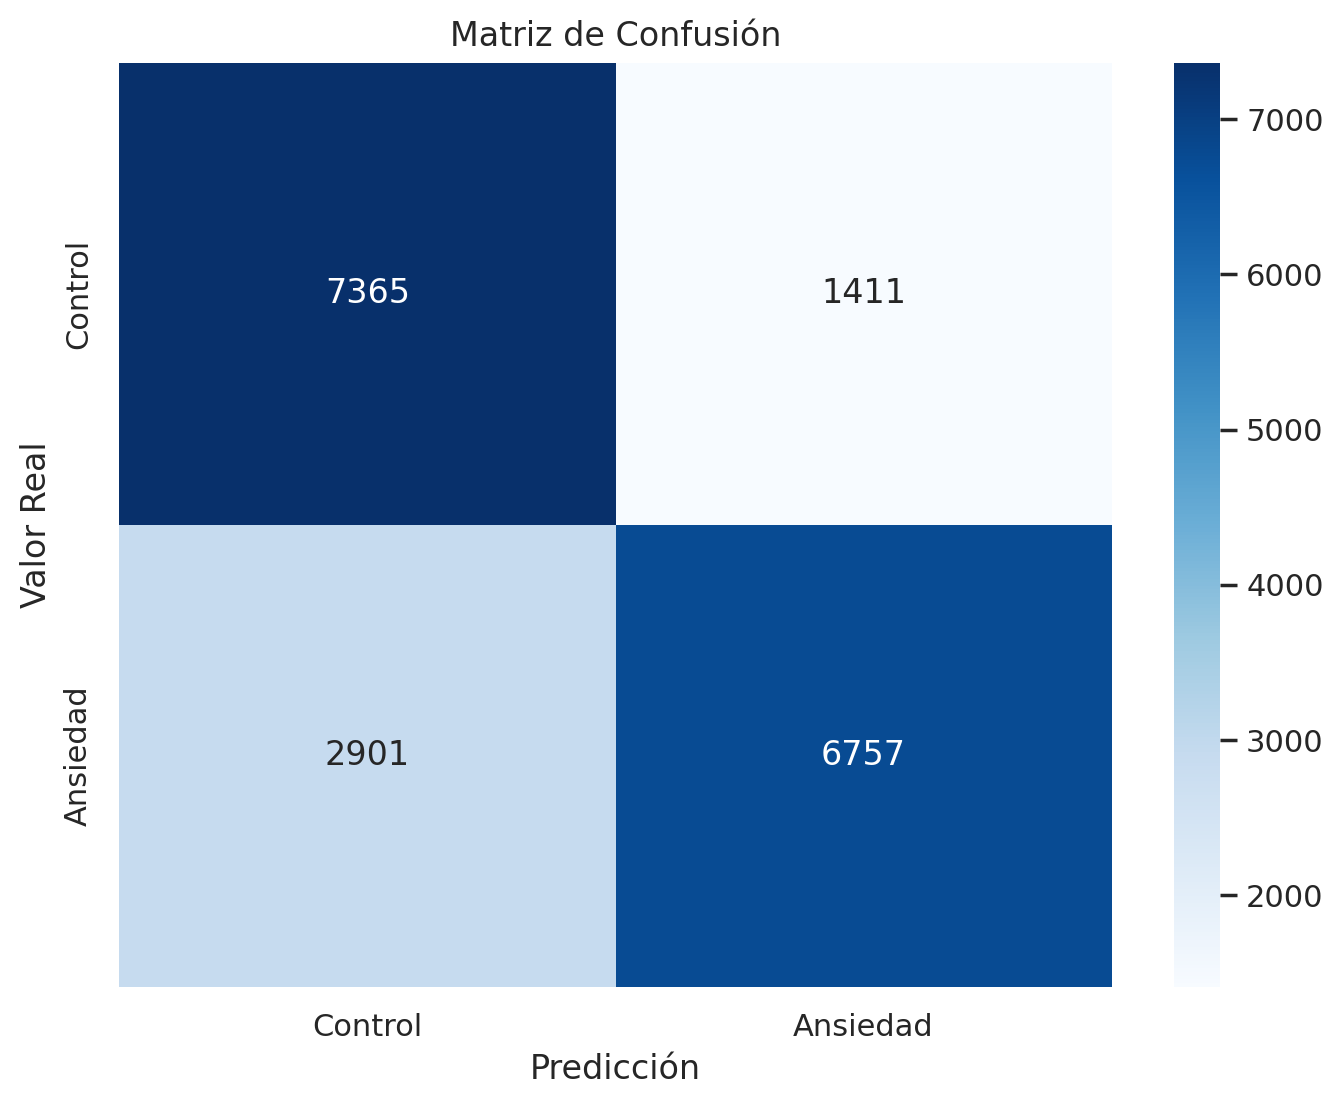

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Crear una figura para la matriz de confusión
plt.figure(figsize=(8, 6))

# Crear una matriz de confusión usando el heatmap de Seaborn
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Control', 'Ansiedad'], yticklabels=['Control', 'Ansiedad'])

# Etiquetas y título
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.title('Matriz de Confusión')

# Mostrar la gráfica
plt.show()

# Aprensizaje del modelo: Red neuronal
**Validación Cruzada K=10**

In [ ]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.decomposition import LatentDirichletAllocation as LDA
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Definir la estrategia de validación cruzada (k=10)
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Listas para almacenar métricas de entrenamiento y validación
train_accuracy_scores = []
train_precision_scores = []
train_recall_scores = []
train_f1_scores = []

val_accuracy_scores = []
val_precision_scores = []
val_recall_scores = []
val_f1_scores = []

# Realizar la validación cruzada
for train_index, val_index in cv.split(X_train_lda, y_train):
    X_train_index, X_val_index = X_train_lda[train_index], X_train_lda[val_index]
    y_train_index, y_val_index = y_train[train_index], y_train[val_index]

    # Comprobar valores NaN en y_train_index
    nan_indices_train = np.isnan(y_train_index)
    if np.any(nan_indices_train):
        X_train_index = X_train_index[~nan_indices_train]
        y_train_index = y_train_index[~nan_indices_train]

    # Crear una red neuronal secuencial
    model = Sequential()

    # Agregar una capa de entrada con el número de características (tópicos) en tu matriz LDA
    model.add(Dense(128, activation='relu', input_dim=X_train_index.shape[1]))
    model.add(Dropout(0.1))  # Dropout para regularización

    # Agregar una capa oculta
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.1))  # Dropout para regularización

    # Agregar una capa de salida con una neurona y función de activación sigmoide para clasificación binaria
    model.add(Dense(1, activation='sigmoid'))

    # Compilar el modelo
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Entrenar el modelo en los datos de entrenamiento
    model.fit(X_train_index, y_train_index, epochs=10, batch_size=50, verbose=0)

    # Evaluar el modelo en el conjunto de entrenamiento
    y_train_pred = (model.predict(X_train_index) > 0.5).astype(int)

    # Calcular métricas de entrenamiento y agregarlas a las listas
    train_accuracy_scores.append(accuracy_score(y_train_index, y_train_pred))
    train_precision_scores.append(precision_score(y_train_index, y_train_pred))
    train_recall_scores.append(recall_score(y_train_index, y_train_pred))
    train_f1_scores.append(f1_score(y_train_index, y_train_pred))

    # Evaluar el modelo en el conjunto de validación
    y_val_pred = (model.predict(X_val_index) > 0.5).astype(int)

    # Calcular métricas de validación y agregarlas a las listas
    val_accuracy_scores.append(accuracy_score(y_val_index, y_val_pred))
    val_precision_scores.append(precision_score(y_val_index, y_val_pred))
    val_recall_scores.append(recall_score(y_val_index, y_val_pred))
    val_f1_scores.append(f1_score(y_val_index, y_val_pred))

# Calcular las métricas promediadas en entrenamiento
train_accuracy_mean = np.mean(train_accuracy_scores)
train_precision_mean = np.mean(train_precision_scores)
train_recall_mean = np.mean(train_recall_scores)
train_f1_mean = np.mean(train_f1_scores)

# Imprimir las métricas en entrenamiento
print("Entrenamiento - Accuracy: {:.2f}%".format(100 * train_accuracy_mean))
print("Entrenamiento - Precision: {:.2f}%".format(100 * train_precision_mean))
print("Entrenamiento - Recall: {:.2f}%".format(100 * train_recall_mean))
print("Entrenamiento - F1 Score: {:.2f}%".format(100 * train_f1_mean))

# Calcular las métricas promediadas en validación
val_accuracy_mean = np.mean(val_accuracy_scores)
val_precision_mean = np.mean(val_precision_scores)
val_recall_mean = np.mean(val_recall_scores)
val_f1_mean = np.mean(val_f1_scores)

# Imprimir las métricas en validación
print("Validación - Accuracy: {:.2f}%".format(100 * val_accuracy_mean))
print("Validación - Precision: {:.2f}%".format(100 * val_precision_mean))
print("Validación - Recall: {:.2f}%".format(100 * val_recall_mean))
print("Validación - F1 Score: {:.2f}%".format(100 * val_f1_mean))

# Guardar el modelo entrenado
model.save('/content/drive/MyDrive/Experimentación Python Tesis /Experimento Dataset Ansiedad /LDA/parametros /modelo_TFIDF_entrenado_LDA(K=10).h5')

# Cargar el modelo entrenado
loaded_model = tf.keras.models.load_model('/content/drive/MyDrive/Experimentación Python Tesis /Experimento Dataset Ansiedad /LDA/parametros /modelo_TFIDF_entrenado_LDA(K=10).h5')


135/135 [==============================] - 0s 2ms/step
Entrenamiento - Accuracy: 76.49%
Entrenamiento - Precision: 81.98%
Entrenamiento - Recall: 70.84%
Entrenamiento - F1 Score: 75.97%
Validación - Accuracy: 76.43%
Validación - Precision: 81.99%
Validación - Recall: 70.68%
Validación - F1 Score: 75.88%


In [ ]:
# Imprimir las métricas promediadas
print("Métricas de entrenamiento promediadas:")
print(f"Exactitud: {train_accuracy_mean * 100:.2f}%")
print(f"Precisión: {train_precision_mean * 100:.2f}%")
print(f"Recuperación: {train_recall_mean * 100:.2f}%")
print(f"Puntuación F1: {train_f1_mean * 100:.2f}%")

print("\nMétricas de validación promediadas:")
print(f"Exactitud: {val_accuracy_mean * 100:.2f}%")
print(f"Precisión: {val_precision_mean * 100:.2f}%")
print(f"Recuperación: {val_recall_mean * 100:.2f}%")
print(f"Puntuación F1: {val_f1_mean * 100:.2f}%")

Métricas de entrenamiento promediadas:
Exactitud: 76.49%
Precisión: 81.98%
Recuperación: 70.84%
Puntuación F1: 75.97%

Métricas de validación promediadas:
Exactitud: 76.43%
Precisión: 81.99%
Recuperación: 70.68%
Puntuación F1: 75.88%


In [ ]:
from sklearn.metrics import confusion_matrix
with tf.device('/device:CPU:0'):
  y_pred = model.predict(X_val_index)

# Obtiene la matriz de confusión. Las filas corresponden a las clases reales,
umbral = 0.5  # Puedes ajustar este umbral según tus necesidades
y_pred_binario = (y_pred > umbral).astype(int)

# Calcular la matriz de confusión con las etiquetas binarias
cm = confusion_matrix(y_val_index, y_pred_binario)
prop_real = np.sum(y_val_index)/len(y_val_index)
prop_etiqutados = (cm[0,1]+cm[1,1])/len(y_val_index)

print("Matriz de confusión: \n\n", cm, "\n")
print('Proporción de comentarios positivos: %.2f'% prop_real)
print('Proporción de comentarios positivos etiquetados: %.2f'% prop_etiqutados)

135/135 [==============================] - 0s 2ms/step
Matriz de confusión: 

 [[1676  368]
 [ 626 1631]] 

Proporción de comentarios positivos: 0.52
Proporción de comentarios positivos etiquetados: 0.46


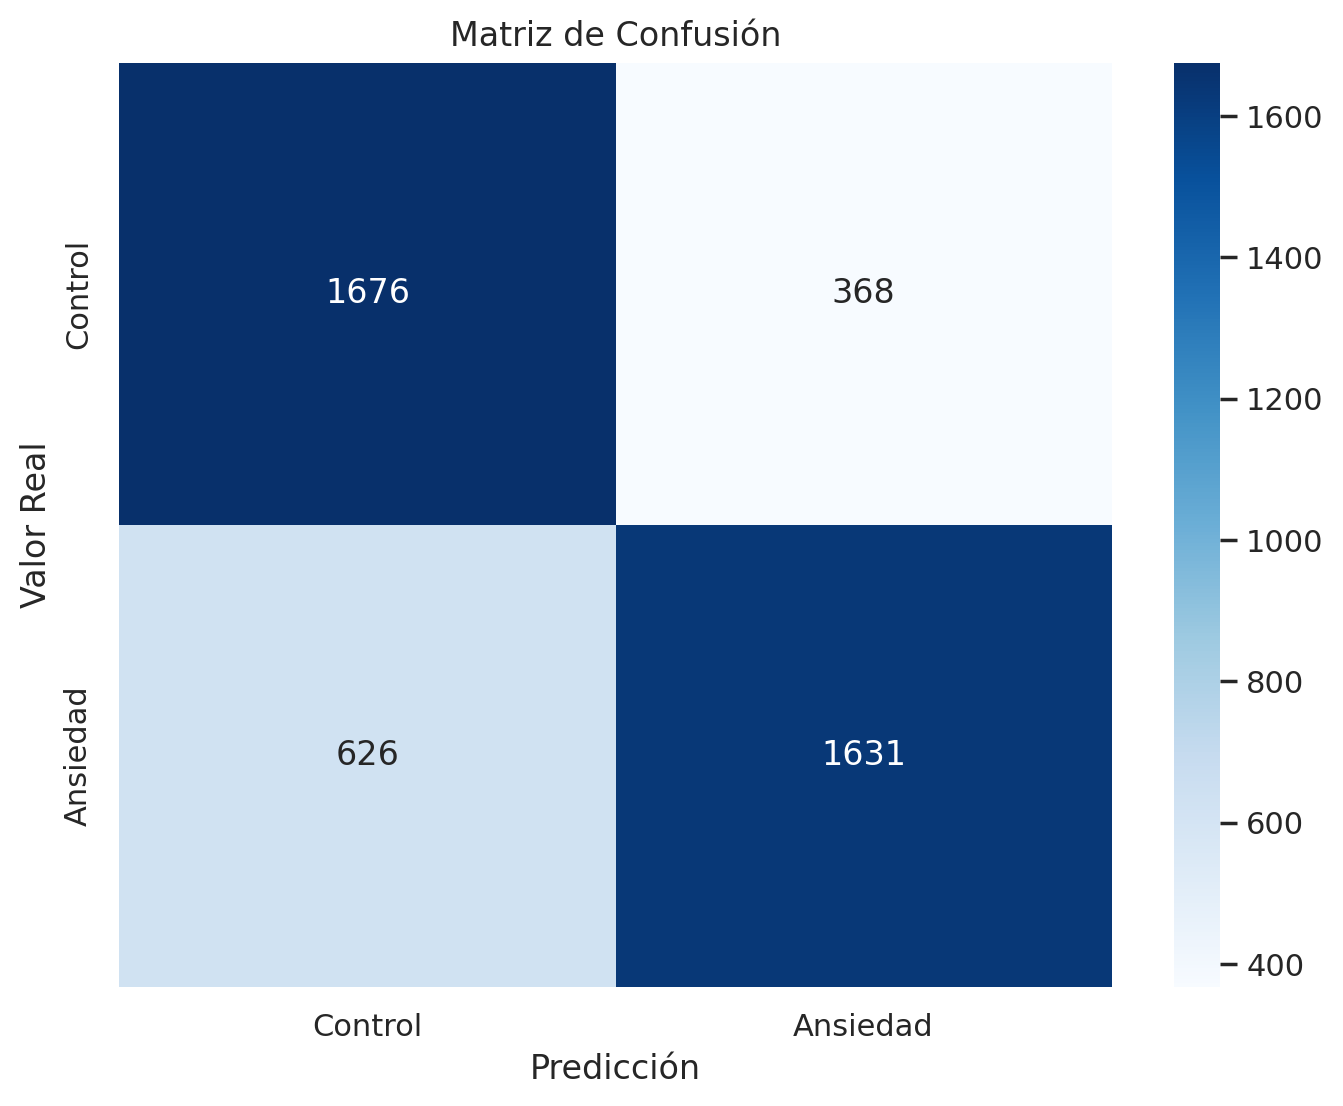

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Crear una figura para la matriz de confusión
plt.figure(figsize=(8, 6))

# Crear una matriz de confusión usando el heatmap de Seaborn
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Control', 'Ansiedad'], yticklabels=['Control', 'Ansiedad'])

# Etiquetas y título
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.title('Matriz de Confusión')

# Mostrar la gráfica
plt.show()

# Guardar el modelo


In [ ]:
import joblib
import os
# Directorio para guardar modelos entrenados
model_dir = '/content/drive/MyDrive/Experimentación Python Tesis /Experimento Dataset Ansiedad /LDA/parametros '
model_filename = 'TWEETS_ansiedad TFIDF(RN-LDA).pkl'
model_path_p = os.path.join(model_dir, model_filename)

# Guardar el modelo entrenado
joblib.dump(model, model_path_p)

['/content/drive/MyDrive/Experimentación Python Tesis /Experimento Dataset Ansiedad /LDA/parametros /TWEETS_ansiedad TFIDF(RN-LDA).pkl']